# Assignment 1 - Gene Chen

In [36]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import cluster
from sklearn import preprocessing
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

my_dtype = {
    'NPI':object, 'NPPES_PROVIDER_LAST_ORG_NAME':object, 'NPPES_PROVIDER_FIRST_NAME':object,
       'NPPES_PROVIDER_MI':object, 'NPPES_CREDENTIALS':object, 'NPPES_PROVIDER_GENDER':object,
       'NPPES_ENTITY_CODE':object, 'NPPES_PROVIDER_STREET1':object, 'NPPES_PROVIDER_STREET2':object,
       'NPPES_PROVIDER_CITY':object, 'NPPES_PROVIDER_ZIP':object, 'NPPES_PROVIDER_STATE':object,
       'NPPES_PROVIDER_COUNTRY':object, 'PROVIDER_TYPE':object,
       'MEDICARE_PARTICIPATION_INDICATOR':object, 'PLACE_OF_SERVICE':object, 'HCPCS_CODE':object,
       'HCPCS_DESCRIPTION':object, 'HCPCS_DRUG_INDICATOR':object, 'LINE_SRVC_CNT':float,
       'BENE_UNIQUE_CNT':float, 'BENE_DAY_SRVC_CNT':float, 'AVERAGE_MEDICARE_ALLOWED_AMT':float,
       'AVERAGE_SUBMITTED_CHRG_AMT':float, 'AVERAGE_MEDICARE_PAYMENT_AMT':float,
       'AVERAGE_MEDICARE_STANDARD_AMT':float
}

# Read the medicare data and extract features and labels
medicare = pd.read_csv("../Medicare_Info/Medicare_Provider_Util_Payment_PUF_CY2016.txt",delimiter="\t",dtype=my_dtype)

## Data Cleaning

In [37]:
# Drop first row
medicare.drop(0,axis=0,inplace=True)

# Due to memory limitations on laptop, taking 10% random samples 
(m,n) = medicare.shape
medicareSub = medicare.iloc[np.random.randint(m, size= int(m*.1)),:]

In [38]:
# Drop features with significant missing data
medicareSub.drop(columns=['NPPES_PROVIDER_MI','NPPES_PROVIDER_STREET2'], axis=1, inplace=True)

# Drop features with too many unique instance, will be non-conclusive, and/or can be derived from another feature
medicareSub.drop(columns=['NPPES_PROVIDER_FIRST_NAME','NPPES_PROVIDER_STREET1','NPPES_PROVIDER_COUNTRY','HCPCS_DESCRIPTION','NPPES_PROVIDER_CITY','NPPES_PROVIDER_LAST_ORG_NAME','NPI','NPPES_PROVIDER_CITY','NPPES_CREDENTIALS','HCPCS_CODE'], axis=1, inplace=True)

# Drop all other rows with missing data
medicareSub.dropna(axis=0, inplace=True)

# Extract Features that correspond to business question: States that provide greatest amount of Beneficiaries
medicareSub.drop(columns=['NPPES_ENTITY_CODE','MEDICARE_PARTICIPATION_INDICATOR','PLACE_OF_SERVICE','HCPCS_DRUG_INDICATOR','BENE_DAY_SRVC_CNT','AVERAGE_MEDICARE_ALLOWED_AMT','AVERAGE_SUBMITTED_CHRG_AMT','AVERAGE_MEDICARE_STANDARD_AMT','NPPES_PROVIDER_ZIP','LINE_SRVC_CNT','BENE_UNIQUE_CNT'], axis=1, inplace=True)

C:\Users\genec\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\genec\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Data Exploration

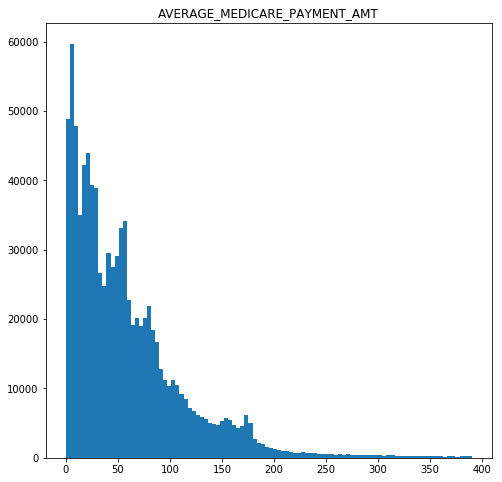

In [42]:
graphs = ['AVERAGE_MEDICARE_PAYMENT_AMT']
plt.figure(figsize=(8,8))
plt.tight_layout()

col = {}
for i in range(len(graphs)):
    col[i] = medicareSub.loc[:,graphs[i]]
    plt.hist(col[i],bins=100,range=(0,col[i].median()+2*col[i].std()))
    plt.title(graphs[i])  

C:\Users\genec\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\genec\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


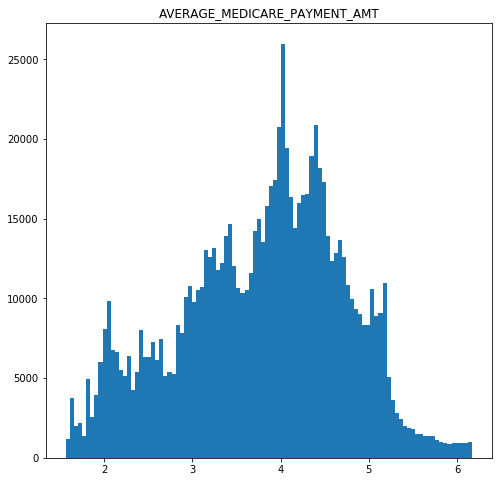

In [43]:
# Heavy skew, attempt to transform with log
plt.figure(figsize=(8,8))
plt.tight_layout()

for i in range(len(graphs)):
    medicareSub[graphs[i]] = medicareSub[graphs[i]] + (1-medicareSub[graphs[i]].min())
    medicareSub[graphs[i]] = np.log(medicareSub[graphs[i]])
    plt.hist(medicareSub[graphs[i]],bins=100,range=(medicareSub[graphs[i]].median()-2*medicareSub[graphs[i]].std(),medicareSub[graphs[i]].median()+2*medicareSub[graphs[i]].std()))
    plt.title(graphs[i]) 

## Clustering

In [48]:
# Changing categorical features to integer using one hot encoding
d1 = pd.get_dummies(medicareSub['NPPES_PROVIDER_STATE'])
d2 = pd.get_dummies(medicareSub['PROVIDER_TYPE'])
d3 = pd.get_dummies(medicareSub['NPPES_PROVIDER_GENDER'])

medicareSub.drop(columns = ['NPPES_PROVIDER_STATE','PROVIDER_TYPE','NPPES_PROVIDER_GENDER'], inplace = True)
medicareSub = pd.concat([medicareSub, d1, d2], axis = 1)

C:\Users\genec\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [49]:
# Normalizing data
medCols = medicareSub.columns
medicareSub = preprocessing.scale(medicareSub)
medicareSub = pd.DataFrame(medicareSub, columns=medCols)

C:\Users\genec\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Determine k
sse = {}
sil = {}
for k in range(1, 10):
    kmeans = cluster.MiniBatchKMeans(k).fit(medicareSub)
    sse[k] = kmeans.inertia_
    cluster_labels = kmeans.fit_predict(medicareSubCopy)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [52]:
# Execute kmeans with k = 7
kmeans = cluster.MiniBatchKMeans(7,n_init=10).fit(medicareSub)
medicareSub['clusters'] = kmeans.labels_

## Analysis

Text(0.5, 1.0, 'Cluster v. Avg Medicare Payment')

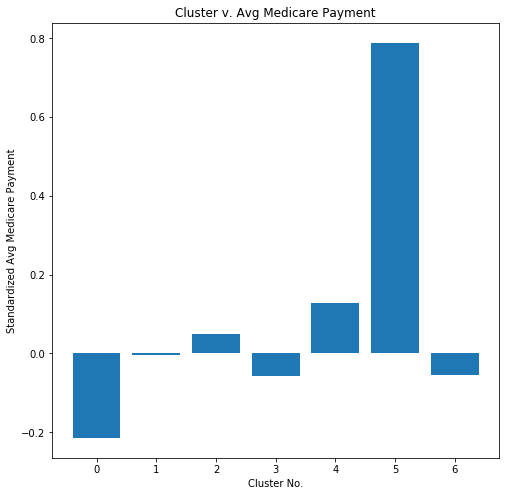

In [57]:
# Determine Cluster with Highest Avg Medicare Payment
a = kmeans.cluster_centers_[:,0].max()
y = kmeans.cluster_centers_[:,0]
x = [0,1,2,3,4,5,6]
plt.figure(figsize = (8,8))
plt.bar(x,y)
plt.xlabel('Cluster No.')
plt.ylabel('Standardized Avg Medicare Payment')
plt.title('Cluster v. Avg Medicare Payment')

Text(0.5, 1.0, 'Largest Presence by State in Cluster No. 5')

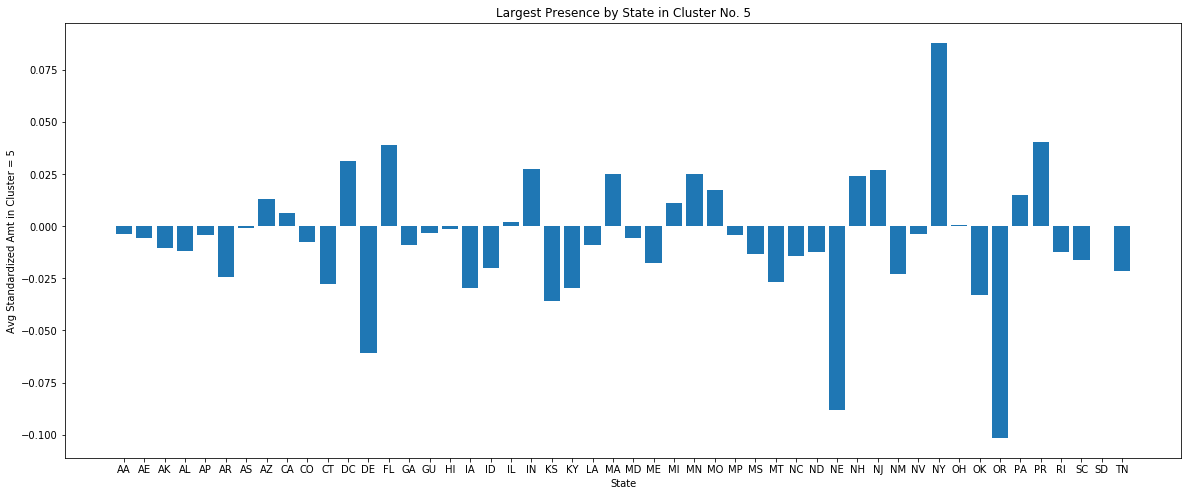

In [56]:
# Determine most affluent state in cluster No. 4
medicareSub['clusters'] = kmeans.labels_
states = medicareSub.loc[medicareSub['clusters']==5]
y = states.iloc[:,1:51].mean()
x = states.iloc[:,1:51].columns

plt.figure(figsize=(20,8))
plt.bar(x,y)
plt.xlabel('State')
plt.ylabel('Avg Standardized Amt in Cluster = 5')
plt.title('Largest Presence by State in Cluster No. 5')